Initial memory usage: 1053.30 MB
Memory usage after optimization: 548.59 MB
Data imported and memory optimized in 8.83 seconds
Data shape: (11504798, 11), Memory usage: 548.59 MB
Stratified sample created in 7.82 seconds
Sample data shape: (230095, 11), Memory usage: 10.97 MB
Feature engineering completed in 1.37 seconds
Data shape after feature engineering: (230095, 24), Memory usage: 33.79 MB
Training and validation sets created in 0.12 seconds
Training set shape: (184076, 23), Memory usage: 26.86 MB
Validation set shape: (46019, 23), Memory usage: 6.71 MB
Data transformed in 0.29 seconds
Transformed training set shape: (184076, 25), Memory usage: 35.11 MB
Transformed validation set shape: (46019, 25), Memory usage: 8.78 MB
Feature selection completed in 294.66 seconds


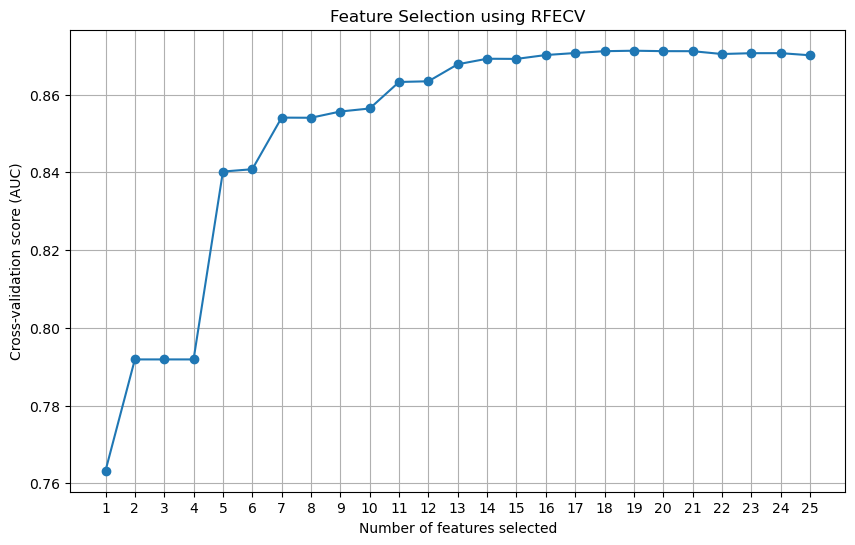

Optimal number of features: 19
Best cross-validation score (AUC): 0.8713
Selected Features: ['cat__Vehicle_Damage_0' 'cat__Vehicle_Damage_1' 'minmax__Age'
 'minmax__Region_Code' 'minmax__Previously_Insured'
 'minmax__Policy_Sales_Channel' 'minmax__Vintage' 'ordinal__Vehicle_Age'
 'standard__Age_Type' 'standard__Age_x_Vehicle_Age'
 'standard__Age_x_Vehicle_Damage' 'standard__Age_x_Previously_Insured'
 'standard_2__Previously_Insured_x_Policy_Sales_Channel'
 'standard_2__Previously_Insured_x_Vehicle_Damage'
 'standard_2__Previously_Insured_x_Vintage'
 'standard_2__Previously_Insured_x_Age_Type'
 'standard_2__Policy_Sales_Channel_x_Vehicle_Damage'
 'standard_2__Policy_Sales_Channel_x_Age_Type'
 'remainder__Driving_License']
Data transformed to selected features in 0.03 seconds
Selected training set shape: (184076, 19), Memory usage: 26.68 MB
Selected validation set shape: (46019, 19), Memory usage: 6.67 MB
[0]	train-auc:0.85403	valid-auc:0.84919
[100]	train-auc:0.88705	valid-auc:0.86957
[

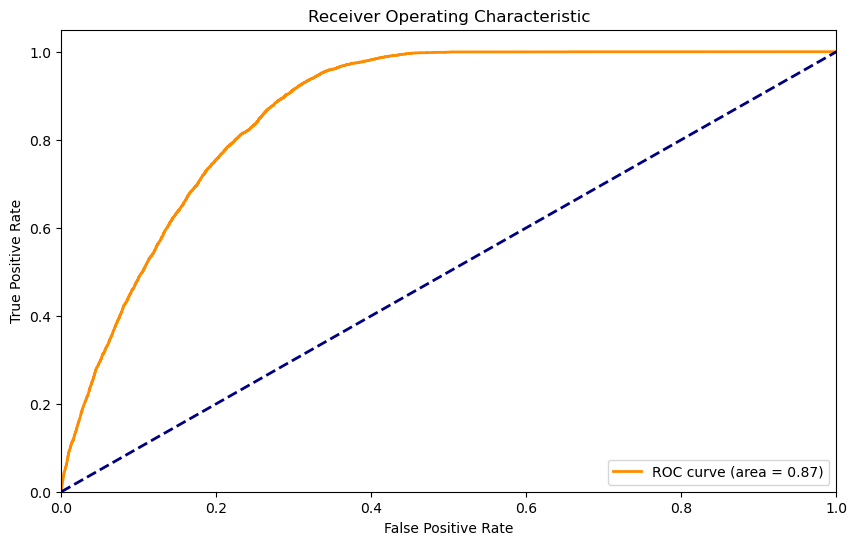

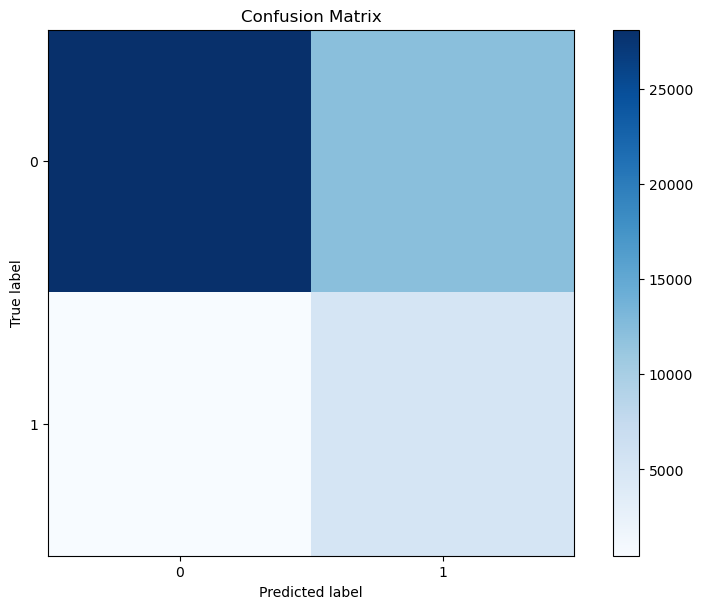

In [12]:
import pandas as pd
import numpy as np
import gc
import time
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, MinMaxScaler, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve, auc
from sklearn.feature_selection import RFECV
import xgboost as xgb
import matplotlib.pyplot as plt

# Paths to datasets
train_path = r"C:\Users\paulo\OneDrive\Documents\kaggle_competition_2_datasets\train.csv"

def import_data(path, index_col=None):
    """Import data from a CSV file and optimize memory usage."""
    start_time = time.time()
    df = pd.read_csv(path, index_col=index_col)
    df = reduce_mem_usage(df)
    print(f"Data imported and memory optimized in {time.time() - start_time:.2f} seconds")
    print(f"Data shape: {df.shape}, Memory usage: {df.memory_usage().sum() / 1024**2:.2f} MB")
    return df

def reduce_mem_usage(df):
    """Iterate through all the columns of a dataframe and modify the data type to reduce memory usage."""
    start_mem = df.memory_usage().sum() / 1024**2
    print(f"Initial memory usage: {start_mem:.2f} MB")
    for col in df.columns:
        col_type = df[col].dtype
        if isinstance(col_type, pd.IntervalDtype):
            continue
        if str(col_type)[:3] == 'int':
            c_min = df[col].min()
            c_max = df[col].max()
            if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                df[col] = df[col].astype(np.int8)
            elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                df[col] = df[col].astype(np.int16)
            elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                df[col] = df[col].astype(np.int32)
            elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                df[col] = df[col].astype(np.int64)  
        elif str(col_type)[:5] == 'float':
            c_min = df[col].min()
            c_max = df[col].max()
            if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                df[col] = df[col].astype(np.float32)
            else:
                df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    print(f"Memory usage after optimization: {end_mem:.2f} MB")
    return df

def feature_engineering(df):
    """Feature engineering on the dataset."""
    start_time = time.time()
    # Binning age and converting to categorical labels instead of intervals
    df.loc[:, 'Age_Type'] = pd.cut(df['Age'], bins=7, labels=False)
    df.loc[:, 'Vehicle_Age'] = pd.Categorical(df['Vehicle_Age']).codes
    df.loc[:, 'Vehicle_Damage'] = pd.Categorical(df['Vehicle_Damage']).codes
    df.loc[:, 'Previously_Insured'] = pd.Categorical(df['Previously_Insured']).codes

    df.loc[:, 'Age_x_Vehicle_Age'] = df['Age_Type'] * df['Vehicle_Age']
    df.loc[:, 'Age_x_Vehicle_Damage'] = df['Age_Type'] * df['Vehicle_Damage']
    df.loc[:, 'Age_x_Previously_Insured'] = df['Age_Type'] * df['Previously_Insured']

    fac_pre = ['Policy_Sales_Channel', 'Vehicle_Damage', 'Annual_Premium', 'Vintage', 'Age_Type']
    col_pre = []
    for i in fac_pre:
        df.loc[:, 'Previously_Insured_x_' + i] = pd.factorize(df['Previously_Insured'].astype(str) + df[i].astype(str))[0]
        col_pre.append('Previously_Insured_x_' + i)

    fac_pro = fac_pre[1:]
    col_pro = []
    for i in fac_pro:
        df.loc[:, 'Policy_Sales_Channel_x_' + i] = pd.factorize(df['Policy_Sales_Channel'].astype(str) + df[i].astype(str))[0]
        col_pro.append('Policy_Sales_Channel_x_' + i)
    print(f"Feature engineering completed in {time.time() - start_time:.2f} seconds")
    print(f"Data shape after feature engineering: {df.shape}, Memory usage: {df.memory_usage().sum() / 1024**2:.2f} MB")
    return df, col_pre, col_pro

# Load and optimize data
train_df = import_data(train_path, index_col='id')

# Create a stratified sample of 2% from the training data
start_time = time.time()
sample_fraction = 0.02
train_sample_df, _ = train_test_split(train_df, stratify=train_df['Response'], test_size=(1 - sample_fraction), random_state=42)
print(f"Stratified sample created in {time.time() - start_time:.2f} seconds")
print(f"Sample data shape: {train_sample_df.shape}, Memory usage: {train_sample_df.memory_usage().sum() / 1024**2:.2f} MB")

# Apply feature engineering to the sampled dataset
train_sample_df, col_pre, col_pro = feature_engineering(train_sample_df)

# Split the training data into training and validation sets
start_time = time.time()
X = train_sample_df.drop('Response', axis=1)
y = train_sample_df['Response']
X_train, X_valid, y_train, y_valid = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
print(f"Training and validation sets created in {time.time() - start_time:.2f} seconds")
print(f"Training set shape: {X_train.shape}, Memory usage: {X_train.memory_usage().sum() / 1024**2:.2f} MB")
print(f"Validation set shape: {X_valid.shape}, Memory usage: {X_valid.memory_usage().sum() / 1024**2:.2f} MB")

# Define the ColumnTransformer
start_time = time.time()
coltrans = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(sparse_output=False, dtype=np.float32), ['Gender', 'Vehicle_Damage']),
        ('minmax', MinMaxScaler(), ['Age', 'Region_Code', 'Previously_Insured', 'Policy_Sales_Channel', 'Vintage']),
        ('ordinal', OrdinalEncoder(categories=[[0, 1, 2]], dtype=np.float32), ['Vehicle_Age']),
        ('robust', RobustScaler(), ['Annual_Premium']),
        ('standard', StandardScaler(), ['Age_Type', 'Age_x_Vehicle_Age', 'Age_x_Vehicle_Damage', 'Age_x_Previously_Insured']),
        ('standard_2', StandardScaler(), col_pre + col_pro),
    ],
    remainder='passthrough'  # Keeps columns not specified in transformers
)

# Fit the transformer on the training data and transform both training and validation sets
X_train = coltrans.fit_transform(X_train)
X_valid = coltrans.transform(X_valid)
print(f"Data transformed in {time.time() - start_time:.2f} seconds")
print(f"Transformed training set shape: {X_train.shape}, Memory usage: {X_train.nbytes / 1024**2:.2f} MB")
print(f"Transformed validation set shape: {X_valid.shape}, Memory usage: {X_valid.nbytes / 1024**2:.2f} MB")

# Get feature names after transformation
feature_names = coltrans.get_feature_names_out()

# Visualize the feature selection process
def plot_rfecv(selector, feature_names):
    """Plot the RFECV scores to visualize the feature selection process."""
    plt.figure(figsize=(10, 6))
    plt.xlabel("Number of features selected")
    plt.ylabel("Cross-validation score (AUC)")
    plt.title("Feature Selection using RFECV")
    plt.plot(range(1, len(selector.cv_results_['mean_test_score']) + 1), selector.cv_results_['mean_test_score'], marker='o')
    plt.xticks(range(1, len(selector.cv_results_['mean_test_score']) + 1))
    plt.grid()
    plt.show()
    
    # Print the optimal number of features and the corresponding score
    optimal_num_features = selector.n_features_
    optimal_score = max(selector.cv_results_['mean_test_score'])
    print(f"Optimal number of features: {optimal_num_features}")
    print(f"Best cross-validation score (AUC): {optimal_score:.4f}")

    # Print the selected features
    selected_features = feature_names[selector.support_]
    print(f"Selected Features: {selected_features}")

# Perform feature selection using RFECV with XGBoost as the estimator
start_time = time.time()
xgb_params = {
    'random_state': 512,
    'objective': "binary:logistic",
    'eval_metric': 'auc',
    'max_depth': 8,
    'min_child_weight': 12,
    'colsample_bytree': 0.5,
    'gamma': 0.2,
    'learning_rate': 0.09093568107192034,
    'subsample': 1.0,
    'reg_alpha': 0.0011852827097616767,
    'reg_lambda': 1.0735757602378362e-06,
    'max_bin': 197818,
    'scale_pos_weight': len(train_sample_df[train_sample_df['Response'] == 0]) / len(train_sample_df[train_sample_df['Response'] == 1]),  # Adjust this based on your dataset
    # 'tree_method': 'hist',  # Ensure your environment supports GPU
    # 'device': 'cuda',  # Ensure your environment supports GPU
}

estimator = xgb.XGBClassifier(**xgb_params)
selector = RFECV(estimator, step=1, cv=StratifiedKFold(5), scoring='roc_auc')
selector = selector.fit(X_train, y_train)
print(f"Feature selection completed in {time.time() - start_time:.2f} seconds")

# Plot the RFECV results
plot_rfecv(selector, feature_names)

# Transform the training and validation data to keep only selected features
start_time = time.time()
X_train_selected = selector.transform(X_train)
X_valid_selected = selector.transform(X_valid)
print(f"Data transformed to selected features in {time.time() - start_time:.2f} seconds")
print(f"Selected training set shape: {X_train_selected.shape}, Memory usage: {X_train_selected.nbytes / 1024**2:.2f} MB")
print(f"Selected validation set shape: {X_valid_selected.shape}, Memory usage: {X_valid_selected.nbytes / 1024**2:.2f} MB")

# Train XGBoost model on selected features
start_time = time.time()
dtrain = xgb.DMatrix(X_train_selected, label=y_train)
dvalid = xgb.DMatrix(X_valid_selected, label=y_valid)

model = xgb.train(
    xgb_params,
    dtrain,
    num_boost_round=3000,
    evals=[(dtrain, 'train'), (dvalid, 'valid')],
    verbose_eval=100,
    early_stopping_rounds=10,
)
print(f"Model training completed in {time.time() - start_time:.2f} seconds")

# Make predictions on the validation set
start_time = time.time()
valid_preds = model.predict(dvalid, iteration_range=(0, model.best_iteration))
auc_score = roc_auc_score(y_valid, valid_preds)
print(f"Validation AUC Score: {auc_score}")
print(f"Validation predictions completed in {time.time() - start_time:.2f} seconds")

# Retrieve the selected features
start_time = time.time()
selected_features = feature_names[selector.support_]
print(f"Selected Features: {selected_features}")
print(f"Selected features retrieved in {time.time() - start_time:.2f} seconds")

# Clear memory
gc.collect()

# Additional analysis and visualization
def plot_roc_curve(y_true, y_pred):
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

def plot_confusion_matrix(y_true, y_pred, threshold=0.5):
    cm = confusion_matrix(y_true, (y_pred > threshold).astype(int))
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['0', '1'])
    plt.yticks(tick_marks, ['0', '1'])
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Plot ROC Curve
plot_roc_curve(y_valid, valid_preds)

# Plot Confusion Matrix
plot_confusion_matrix(y_valid, valid_preds)
